This notebook simply runs one path through the detector with 50 rays from a single point. It graphs the geometric outlines of the simulation's ellipsoids and the subsequent reflections of the 50 rays. It traces only one path through the polarizers, but can be changed to show any of the 8 paths that lead to the detector. (TTTT: transmit transmit transmit transmit, TRTR: transmit reflect transmit reflect etc.) 
Mira Liu 05/26/2019

Cleaned up and improved by Tommy Alford 3/21/2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import RayTraceFunctionsv2

import importlib
importlib.reload(RayTraceFunctionsv2)
#assert RayTraceFunctionsv2.test_dims()
from RayTraceFunctionsv2 import * 

from random import uniform
import random
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio; pio.renderers.default='notebook'
import pickle
import math
import time
import yaml

from scipy.optimize import curve_fit

In [2]:
def get_aspect(config, aspect, element, number):
    '''Obtain the config for a given aspect, element, and number
    
    Parameters:
        config (yaml file)  -- yaml configuration file loaded
        aspect (str)        -- aspect of the FTS (origins, angles, coefficients, etc)
        element (str)       -- element of the FTS for which this aspect is defined 
                              (ellipses, mirror, polarizers)
        number (int)        -- number of the element that we're specifically interested
                            in (1-10 for ellipses, 1-4 for polarizers)'''
    
    def get_item(dic, key, num):
        if type(dic[key]) is dict:
            return dic[key][num]
        else:
            return dic[key]
        
    if element is None:
        return get_item(config, aspect, number)
    else:
        return get_item(config[aspect], element, number)
    
#with open("lab_fts_dims_dicts.yml", "r") as stream:
#    config_v2 = yaml.safe_load(stream)
    
#with open("lab_fts_dims_dicts_old.yml", "r") as stream:
#    config_old = yaml.safe_load(stream)
    
with open("lab_fts_dims_mcmahon.yml", "r") as stream:
    config = yaml.safe_load(stream)
    
#with open("lab_fts_dims_mcmahon_real.yml", "r") as stream:
#    config_real = yaml.safe_load(stream)

# Loading Data from threaded Runs

In [3]:
import notebook_utils
import pickle
import matplotlib.pyplot as plt
import numpy as np
total_attrs_xy = pickle.load(open('total_attrs_xy_15_15_625.p', 'rb'))
data_xy = np.array(total_attrs_xy, dtype='object')
shifts_xy = np.array(list(map(np.array, data_xy[:, 0])))

total_attrs_xyz = pickle.load(open('total_attrs_end_source.p', 'rb'))
data_xyz = np.array(total_attrs_xyz, dtype='object')
shifts_xyz = np.array(list(map(np.array, data_xyz[:, 0])))

/home/talford/FTS_Simulations/fts_coupling_optics_geo.py:223: RuntimeWarning:

invalid value encountered in sqrt



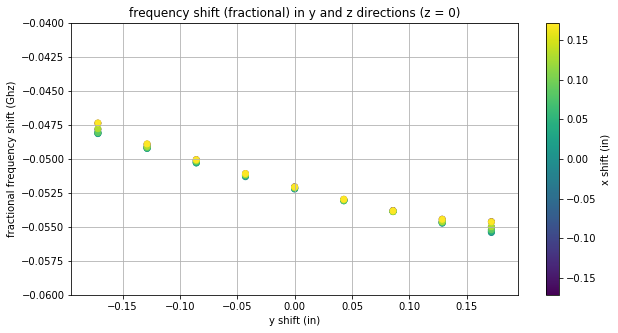

In [4]:
def plot_data(y_data, z_data, values, clabel=None):
    plt.figure(figsize=(10, 5))
    plt.scatter(y_data, values, c=z_data)
    plt.colorbar(label=clabel)
    plt.grid()

s1 = np.where((shifts_xy[:, 2] == 0) & (np.abs(shifts_xy[:, 0]) <= .2) & (np.abs(shifts_xy[:, 1]) <= .2))
#s1 = np.where((shifts_xy[:, 0]) == 0)
plot_data(shifts_xy[:, 1][s1], shifts_xy[:, 0][s1], data_xy[:, 4][s1], clabel='x shift (in)')
plt.ylim(-.06, -.04)
plt.xlabel('y shift (in)')
plt.ylabel('fractional frequency shift (Ghz)')
plt.title('frequency shift (fractional) in y and z directions (z = 0)')
plt.show()

In [5]:
def get_amplitude_at_one_frequency(freq, data):
    vals = []
    amplitude_data = data[:, 3]
    freqs = data[:, -2][0]
    freq_ind = np.where(freqs == freq)[0][0]
    for amps in amplitude_data:
        vals.append(amps[freq_ind])
    vals = np.array(vals)
        
    mean, std = notebook_utils.smart_rms(vals, 5, 5)
    for i, val in enumerate(vals):
        if np.abs(mean - val) > 3 * std:
            vals[i] = 0
    return vals

vals_150 = get_amplitude_at_one_frequency(150, data_xy[s1])

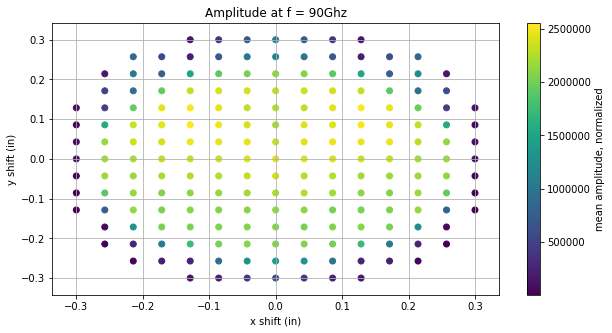

In [6]:
plt.figure(figsize=(10, 5))
s1 = np.where((shifts_xy[:, 2] == 0) & (np.abs(shifts_xy[:, 0]) <= .2) & (np.abs(shifts_xy[:, 1]) <= .2))
s1 = np.ones(len(shifts_xy), dtype='bool')
#plt.scatter(shifts_xy[s1][:, 0], shifts_xy[s1][:, 1], c=data_xy[s1][:, 6])

vals_150 = get_amplitude_at_one_frequency(150, data_xy[s1])

vals_150_db = 8.69 * np.log(vals_150 / np.max(vals_150))
plt.scatter(shifts_xy[s1][:, 0], shifts_xy[s1][:, 1], c=vals_150)
plt.colorbar(label='mean amplitude, normalized')
plt.xlabel('x shift (in)')
plt.ylabel('y shift (in)')
plt.title('Amplitude at f = 90Ghz')
plt.grid()

In [7]:
import notebook_utils
import importlib
importlib.reload(notebook_utils)

def get_shift_index(data, shift):
    return np.where(np.array([(np.round(data[i][0], 2) == shift).all() for i in range(
        len(data))]) == True)[0][0]

n = get_shift_index(data_xyz, [0, 0, 0])
rays = data_xyz[n][-1]
delay = data_xyz[n][1]
shift = data_xyz[n][0]
#_ = notebook_utils.plot_shifts(delay, rays, np.arange(15, 301), 20, shift=shift, plot=True)

In [8]:
np.unique(shifts_xy[:, 1])

array([-0.3       , -0.25714286, -0.21428571, -0.17142857, -0.12857143,
       -0.08571429, -0.04285714,  0.        ,  0.04285714,  0.08571429,
        0.12857143,  0.17142857,  0.21428571,  0.25714286,  0.3       ])

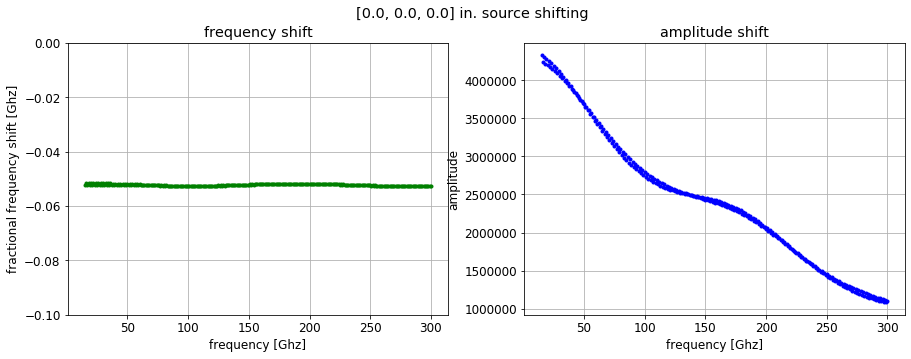

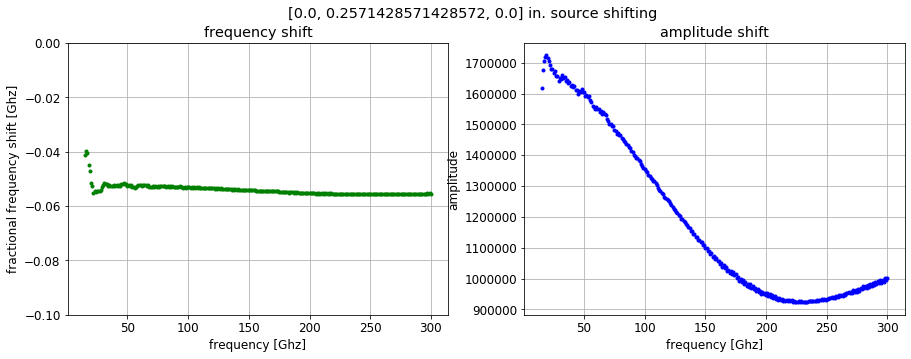

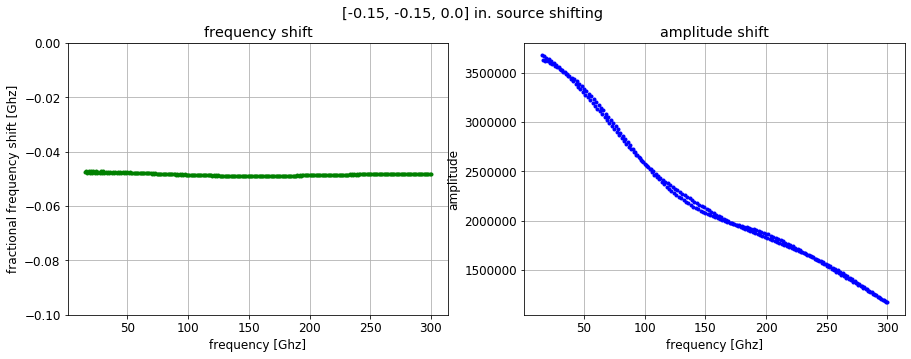

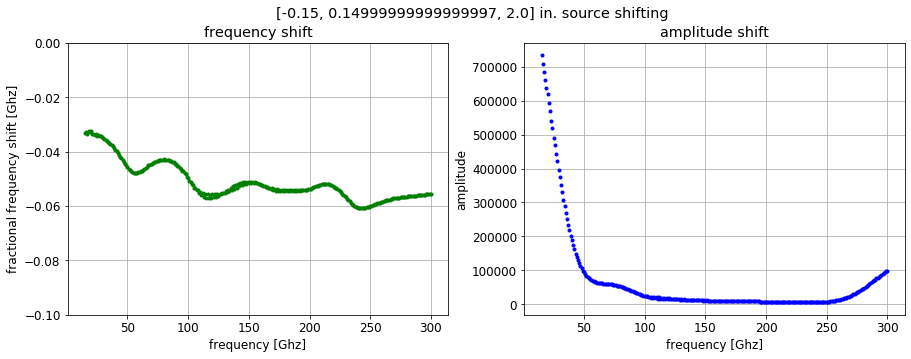

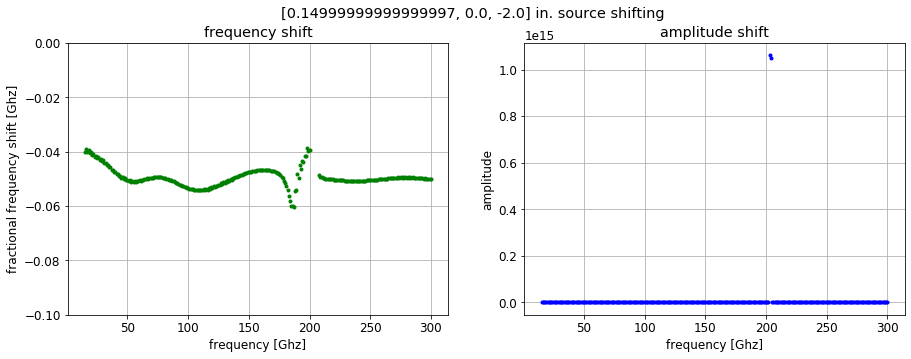

In [9]:
importlib.reload(notebook_utils)
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
def plot_data(data, shift):
    n = get_shift_index(data, shift)
    rays = data[n][-1]
    delay = data[n][1]
    shift = data[n][0]

    gaussian_shifts = data[n][2]
    gaussian_amplitudes = data[n][3]
    importlib.reload(notebook_utils)
    #_ = notebook_utils.plot_shifts(delay, rays, np.arange(15, 301), 20, shift=[0, 0, -2], plot=True)
    notebook_utils.plot_shifts_end(shift, np.arange(15, 301), gaussian_shifts, gaussian_amplitudes)
    
plot_data(data_xy, [0, -0, 0])
plot_data(data_xy, [0, .26, 0])
plot_data(data_xyz, [-.15, -.15, 0])
plot_data(data_xyz, [-.15, .15, 2])
plot_data(data_xyz, [.15, 0, -2])

# Tests with the path length difference

In [10]:
import coupling_optics_sims as csims
import notebook_utils
#importlib.reload(coupling_optics_sims)
rays_test = csims.get_final_rays([0, 0, 0], 6, theta_bound=.001, y_ap=-.426)
transformed_test = notebook_utils.transform_rays_perfect(rays_test, config, debug=False)

possible_paths = get_possible_paths()
points1, vectors1, total_distances1 = notebook_utils.step_rays(
    transformed_test, config, run_ray_through_sim, config, [0, 10, 0], 
    possible_paths[5], final_dist=238)

points2, vectors2, total_distances2 = notebook_utils.step_rays(
    transformed_test, config, run_ray_through_sim, config, [0, 10, 0], 
    possible_paths[6], final_dist=238)

final ray counts = [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
initial number of rays = 36
total number of rays making past the first ellipse = 36
total number of rays making it all the way through = 36
final ray counts = [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
initial number of rays = 36
total number of rays making past the first ellipse = 36
total number of rays making it all the way through = 36


In [11]:
np.sum(total_distances1[0]), np.sum(total_distances1[1])

(3381.9995206437707, 3381.9980483000413)

In [12]:
np.sum(total_distances2[0]), np.sum(total_distances2[1])

(3419.8226141521664, 3419.821468493308)

In [16]:
(np.sum(total_distances2[0]) - np.sum(total_distances1[0])) / (10 * 4)

0.9455773377098922

In [145]:
delay_test, rays_test = run_all_rays_through_sim_optimized(
    transformed_test, config, 200, paths=possible_paths, ymax=20, progressbar=False)
#plot_freq_interferogram(150, rays_test, delay_test, ymax=20, fac=1)

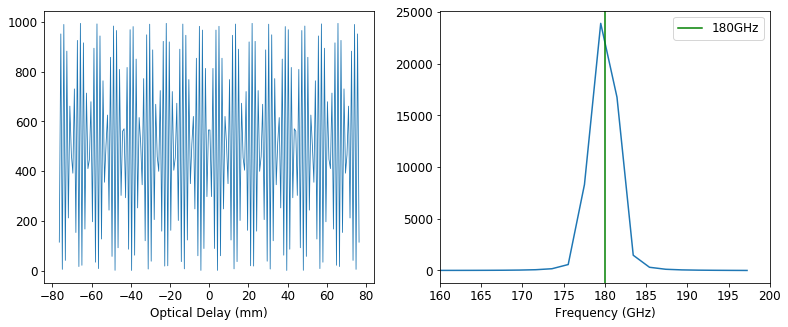

In [179]:
notebook_utils.plot_freq_interferogram(180, rays_test, delay_test, ymax=20, fac=(1 / 1.052))

In [15]:
(np.sum(total_distances2[0][:-2]) - np.sum(total_distances1[0][:-2])) / (4 * 10)

0.945514000335993

In [161]:
1 / (1.052)

0.9505703422053231

In [167]:
total_distances1[0]

[937.151969648173,
 271.11746788279174,
 238.06604220039776,
 238.06155938272968,
 238.06155089389767,
 227.89527066029382,
 0.0,
 227.8794748903133,
 238.83006590224204,
 238.82934029894113,
 238.04601803499145,
 238]

In [168]:
total_distances2[0]

[937.151969648173,
 271.11746788279174,
 238.06604220039776,
 238.06155938272968,
 238.06155089389767,
 248.26297656398378,
 0.0,
 248.24761281510837,
 237.37172009494725,
 237.3724022911906,
 238.0481714651337,
 238]

In [169]:
2 * (248.26) - (2 * 227.90)

40.71999999999997

In [170]:
2 * (237.37) - (2 * 238.83)

-2.920000000000016

In [171]:
40.72 - 2.92

37.8

In [174]:
np.sum(total_distances2[1]) - np.sum(total_distances1[1])

37.8231387240362

In [175]:
(np.sum(total_distances2[1]) - np.sum(total_distances1[1])) / 40

0.945578468100905